# Tests on sequences of data from AirSim

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os
from scipy.spatial.transform import Rotation as R

import planeslam.geometry as geometry
import planeslam.io as io
from planeslam.scanrep import ScanRep, pc_to_scan

Read in airsim LiDAR and pose data

In [2]:
# Read in point cloud data
binpath = os.path.join(os.getcwd(),'..', 'data', 'airsim', 'blocks_20_samples_1', 'lidar', 'Drone0')
PC_data = io.read_lidar_bin(binpath)

In [3]:
# Read in ground-truth poses (in drone local frame)
posepath = os.path.join(os.getcwd(),'..', 'data', 'airsim', 'blocks_20_samples_1', 'poses', 'Drone0')
drone_positions, drone_orientations = io.read_poses(posepath)

Extract planes for LiDAR scans

In [4]:
from planeslam.general import downsample
from planeslam.mesh import LidarMesh
from planeslam.clustering import cluster_mesh_graph_search
from planeslam.extraction import planes_from_clusters

def pc_to_planes(P):
    """Point cloud to planes

    Parameters
    ----------
    P : np.array (n_pts x 3)
        Unorganized point cloud

    Returns
    -------
    ScanRep
        Scan representing input point cloud
    
    """
    # Downsample
    P = downsample(P, factor=5, axis=0)

    # Create the mesh
    mesh = LidarMesh(P)
    # Prune the mesh
    mesh.prune(10)
    # Cluster the mesh with graph search
    clusters, avg_normals = cluster_mesh_graph_search(mesh)

    # Extract planes
    return planes_from_clusters(mesh, clusters, avg_normals)

In [6]:
num_scans = len(PC_data)
scans = num_scans * [None]
planesets = num_scans * [None]
scans_transformed = num_scans * [None]
for i in range(num_scans):
    scans[i] = pc_to_scan(PC_data[i])
    r = R.from_quat(drone_orientations[i,:])
    scans[i].transform(r.as_matrix(), drone_positions[i,:])

    planesets[i] = pc_to_planes(PC_data[i])

Text(0.5, 0.5, 'Y')

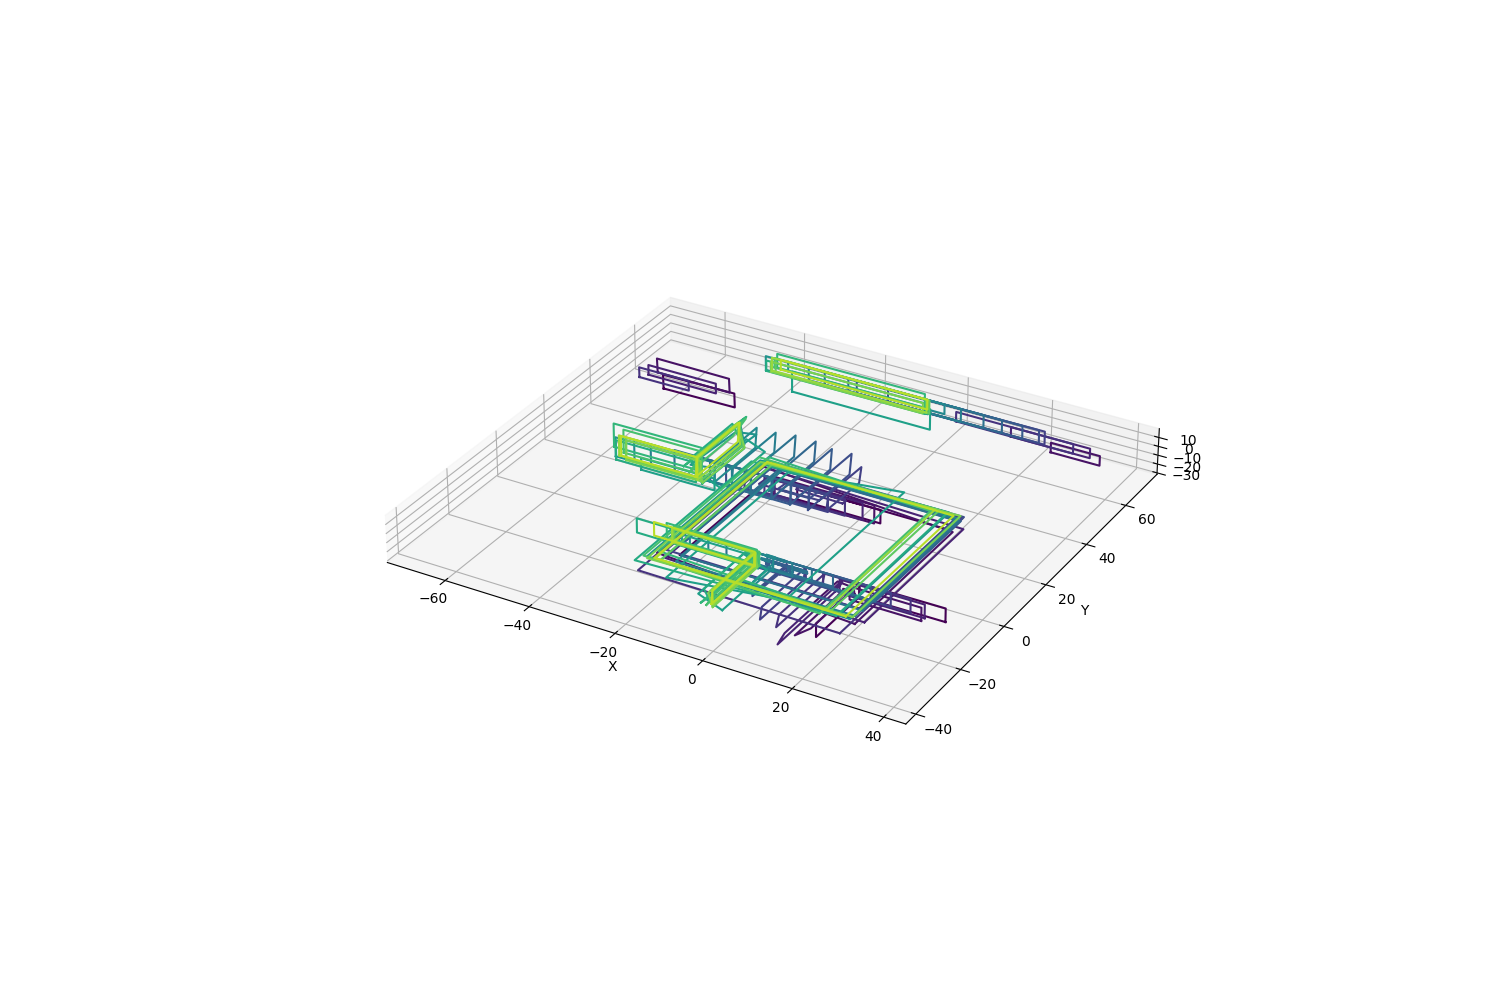

In [7]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
cmap = cm.get_cmap('viridis')
cmap_idxs = int(len(cmap.colors) / num_scans) * np.arange(num_scans)
colors = np.asarray(cmap.colors)[cmap_idxs,:]
for i, planes in enumerate(planesets):
    for p in planes:
        p.plot(ax, color=colors[i])
ax.set_box_aspect((np.ptp(PC_data[0][:,0]), np.ptp(PC_data[0][:,1]), np.ptp(PC_data[0][:,2])))
ax.set_xlabel("X")
ax.set_ylabel("Y")

Text(0.5, 0.5, 'Y')

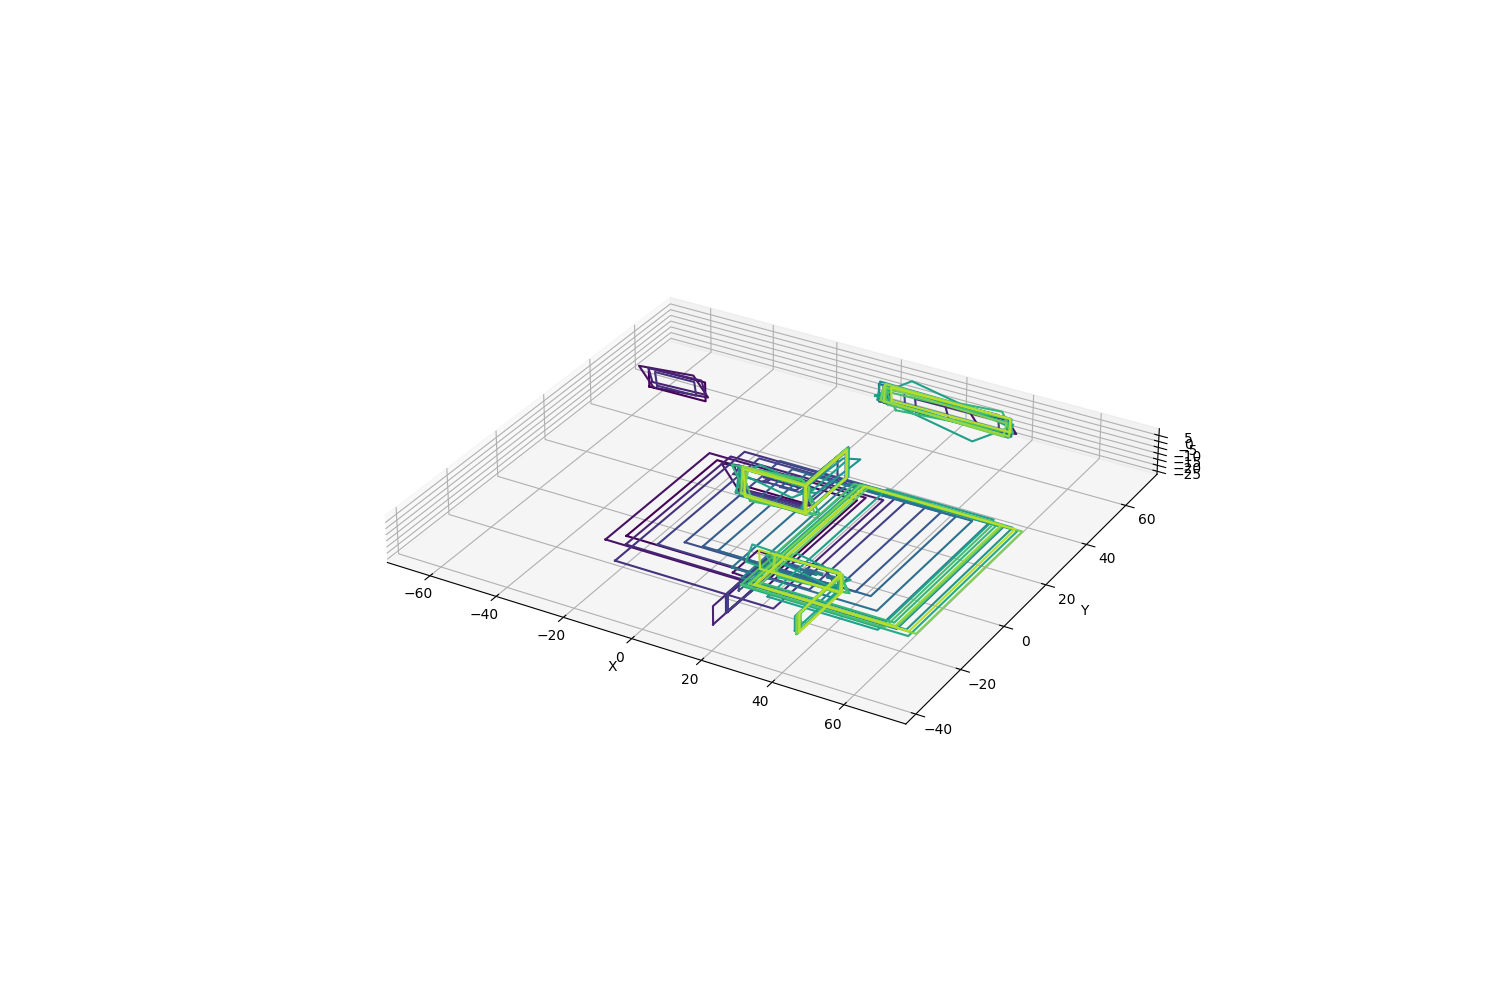

In [5]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
cmap = cm.get_cmap('viridis')
cmap_idxs = int(len(cmap.colors) / num_scans) * np.arange(num_scans)
colors = np.asarray(cmap.colors)[cmap_idxs,:]
for i, s in enumerate(scans):
    s.plot(ax, color=colors[i])
ax.set_box_aspect((np.ptp(PC_data[0][:,0]), np.ptp(PC_data[0][:,1]), np.ptp(PC_data[0][:,2])))
ax.set_xlabel("X")
ax.set_ylabel("Y")

Merge Scans

In [6]:
def merge_scans(scan_1, scan_2, norm_thresh=0.1, dist_thresh=1.0):
    """Merge scans
    
    Merge scan_2 into scan_1. 
    
    """
    merged_planes = []

    # Keep track of which faces in each scan have been matched
    scan_1_matched = []
    scan_2_matched = []  

    for idx_1, face_1 in enumerate(scan_1.faces):
        # Extract vertices and normal
        plane_1 = scan_1.vertices[face_1]
        normal_1 = scan_1.normals[idx_1]
        for idx_2, face_2 in enumerate(scan_2.faces):
            # Extract vertices and normal
            plane_2 = scan_2.vertices[face_2]
            normal_2 = scan_2.normals[idx_2]

            # Check if 2 planes are approximately coplanar
            if np.linalg.norm(normal_1 - normal_2) < norm_thresh:
                
                # Check plane to plane distance
                if geometry.plane_to_plane_dist(plane_1, normal_1, plane_2, normal_2) < dist_thresh:
                    # TODO: check overlap in plane

                    # It's a match! Create merged plane
                    print("match")
                    
                    scan_1_matched.append(idx_1)
                    scan_2_matched.append(idx_2)

                    # Break from inner loop (scan_2)
                    break
            


In [7]:
def project_plane_to_2D(plane, normal):
    """Project a 3D plane to 2D
    
    Project a (rectangularly bounded) plane that exists in 3D into its 
    2D subspace based on its normal vector.
    
    """
    # Normal vector 


In [8]:
scan_1 = scans[0]
scan_2 = scans[1]

face_1 = scan_1.faces[0]
plane_1 = scan_1.vertices[face_1]
centroid_1 = np.mean(plane_1, axis=0)
normal_1 = scan_1.normals[0]

face_2 = scan_2.faces[0]
plane_2 = scan_2.vertices[face_2]
centroid_2 = np.mean(plane_2, axis=0)
normal_2 = scan_2.normals[0]

geometry.plane_to_plane_dist(plane_1, normal_1, plane_2, normal_2)

0.17427811556315717

In [9]:
def face_correspondences(scan_1, scan_2, norm_thresh=0.1, dist_thresh=1.0):
    for idx_1, face_1 in enumerate(scan_1.faces):
        # Extract vertices and normal
        plane_1 = scan_1.vertices[face_1]
        normal_1 = scan_1.normals[idx_1]
        for idx_2, face_2 in enumerate(scan_2.faces):
            # Extract vertices and normal
            plane_2 = scan_2.vertices[face_2]
            normal_2 = scan_2.normals[idx_2]
            # Check if 2 planes are approximately coplanar
            if np.linalg.norm(normal_1 - normal_2) < norm_thresh:
                print("norm check")
                # Check plane to plane distance
                p2p_dist = geometry.plane_to_plane_dist(plane_1, normal_1, plane_2, normal_2)
                if p2p_dist < dist_thresh:
                    print("dist check: ", p2p_dist)
                    # TODO: check overlap in plane
                    # Create merged plane
            

In [12]:
face_correspondences(scans[0], scans[1])

norm check
dist check:  0.17427811556315717
norm check
dist check:  0.004406330746108685
norm check
norm check
norm check
dist check:  0.30722812499998187
norm check
dist check:  0.09206825492684584
norm check
norm check
dist check:  0.05435397362547822
norm check


Text(0.5, 0.5, 'Y')

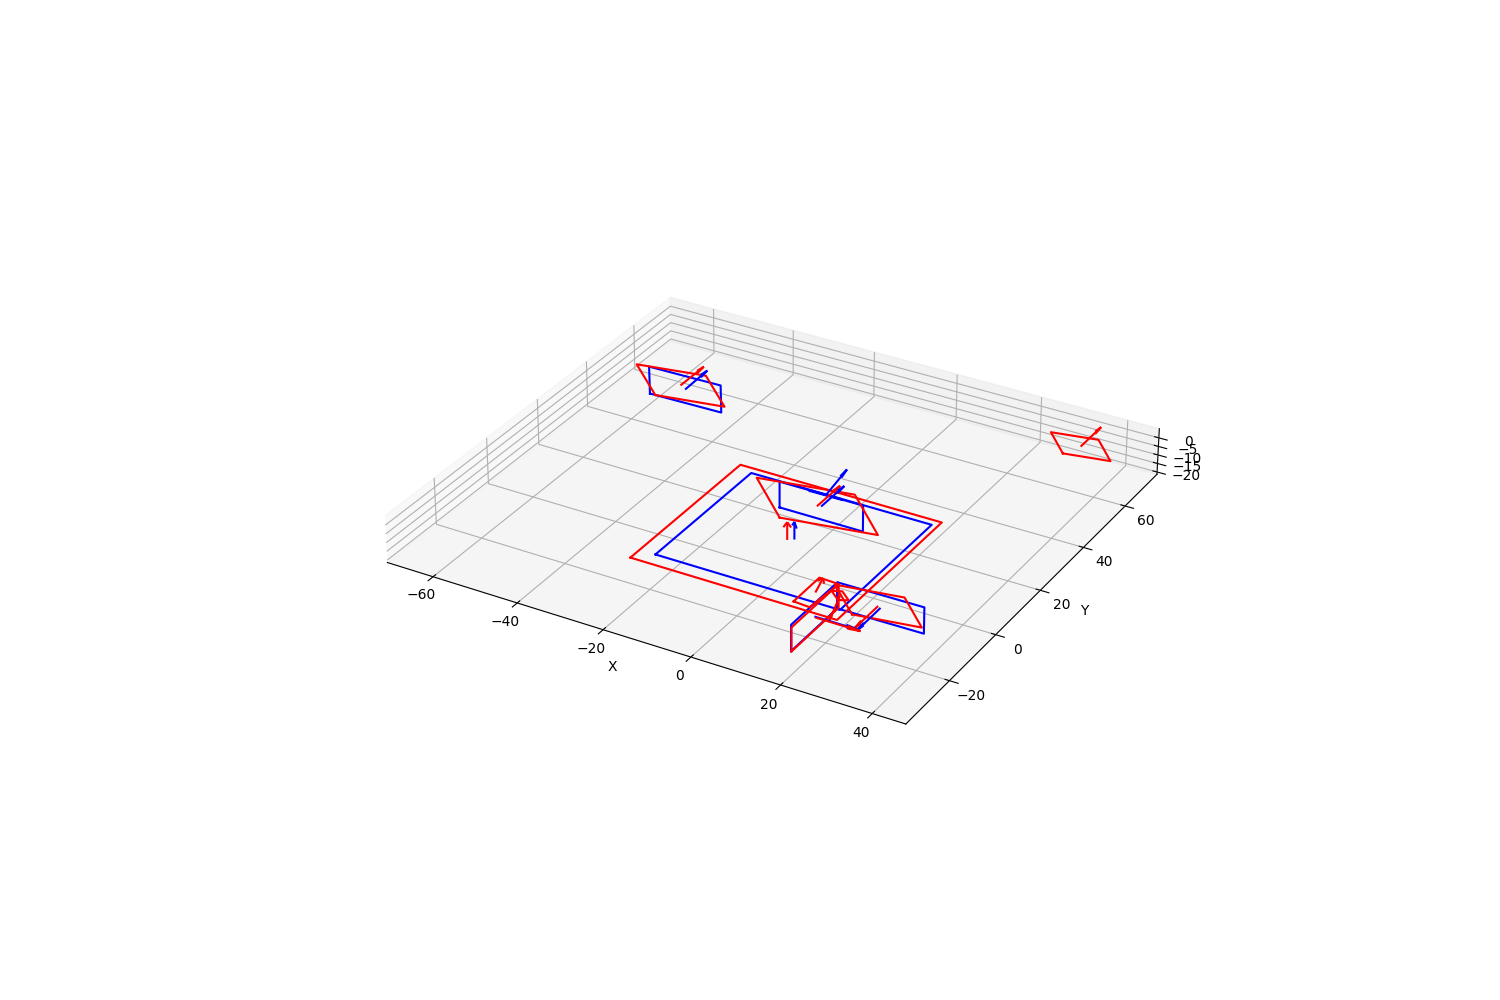

In [7]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

scans[0].plot(ax, color='b', show_normals=True)
scans[1].plot(ax, color='r', show_normals=True)

# for idx, face in enumerate(scans[0].faces):
#     face_verts = scans[0].vertices[face]
#     c = np.mean(face_verts, axis=0)
#     n = 10*scans[0].normals[idx]
#     ax.quiver(c[0], c[1], c[2], n[0], n[1], n[2], color='b')

# for idx, face in enumerate(scans[1].faces):
#     face_verts = scans[1].vertices[face]
#     c = np.mean(face_verts, axis=0)
#     n = 10*scans[0].normals[idx]
#     ax.quiver(c[0], c[1], c[2], n[0], n[1], n[2], color='b')

ax.set_box_aspect((np.ptp(PC_data[0][:,0]), np.ptp(PC_data[0][:,1]), np.ptp(PC_data[0][:,2])))
ax.set_xlabel("X")
ax.set_ylabel("Y")